In [24]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import ndimage
import glob

In [25]:
try:
    plt.style.use('./jupyter.mplstyle')
except:
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = 16, 6
    mpl.rcParams['font.sans-serif'] = 'Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif'
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.size'] = 16

In [26]:
obj = '2306'
ztime = 2454967.39 # the time of first eclipse across all time
period = 10.3

order = 13
xi_h = 2.0
xi_l = 0.5
final_xi_h = 1.0
final_xi_l = 1.0

files = '/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data'
detrended = '/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data' + obj + 'detrended.dat'

In [27]:
f = open(detrended, "w+")
f.write('#BJD, flux, uncertainity')
f.close()

In [28]:
def calc_baseline(d, init_sigma, order, xi_l, xi_h):
    '''
        Calculates baseline of the data

    '''

    coeffs = np.polynomial.legendre.legfit(d[:, 0], d[:, 1], order , w = d[:, 2])
    baseline = np.polynomial.legendre.legval(d[:, 0], coeffs, tensor = False)

    flt = (d[:, 1] - baseline < xi_h * init_sigma) & (d[:, 1] - baseline > -xi_l * init_sigma)
    return flt, baseline

In [29]:
def sigclip(d, init_sigma, order, xi_l, xi_h):
    '''
        Removes the eclipses from the data

    '''

    flt, baseline = calc_baseline(d, init_sigma, order, xi_l, xi_h)

    culled_data = d[flt]
    culled_points = len(d) - len(culled_data)
    print(f'{culled_points} datapoints culled')

    while culled_points > 0:
        flt, baseline = calc_baseline(culled_data, init_sigma, order, xi_l, xi_h)
        culled_points = len(culled_data) - len(culled_data[flt])
        culled_data = culled_data[flt]
        print(f'{culled_points} datapoints culled')

    plt.plot(d[:, 0], d[:, 1], 'r.')
    plt.plot(culled_data[:, 0], culled_data[:, 1], 'g.')
    plt.plot(culled_data[:, 0], baseline, 'b-')
    plt.xlabel('Time (scaled between 0 & 1)')
    plt.ylabel('Flux')
    plt.title('Initial Sigma Clipping to Remove Eclipses and fit Baseline')
    plt.show()

    return culled_data, baseline

In [30]:
def final_sigclip(d, xi_l, xi_h):

    init_sigma = np.nanstd(d[:, 3])

    # sort the array by phase
    arg1 = np.argsort(d[:, 5])
    d = d[arg1]

    # create a baseline with running median
    new_baseline = ndimage.median_filter(d[:, 3], size = int(len(d[:, 0]) / 500))
    flt = (d[:, 3] - new_baseline < xi_h *init_sigma) & (d[:, 3] - new_baseline > -xi_l*init_sigma)
    new_baseline = new_baseline[flt]

    plt.plot(d[:,5], d[:,3], 'r.')
    plt.plot(d[:,5][flt], d[:,3][flt], 'g.')
    plt.plot(d[:,5][flt], new_baseline, 'b-')
    plt.xlabel("Time scaled between 0 & 1")
    plt.ylabel("Flux")
    plt.title("Final Sigma Clip to Remove Spurious Points")
    plt.show() 

    d = d[flt]
    return d, new_baseline

In [31]:
def detrend (data, order, xi_h, xi_l, ztime, period):
    '''
        Detrends the single light curve

    '''

    # arg = np.where((data[:, 2] != ('-inf')) &  (data[:, 2] != ('inf')) & (data[:, 3] != ('-inf')) & (data[:, 3] != ('-inf')))

    finite_mask = np.isfinite(data[:, 2]) & np.isfinite(data[:, 3])
    arg = np.where(finite_mask)[0]
    d = np.empty([len(data[:, 2][arg]), 6])

    d[:, 0] = data[:, 1][arg] # Time   
    d[:, 1] = data[:, 2][arg] # Raw Flux
    d[:, 2] = data[:, 3][arg] # Raw Flux Error
    d[:, 5] = (d[:, 0] - ztime) / period # add phase column

    tmin, tmax = d[:, 0][0], d[:, 0][-1]
    d[:, 0] = (d[:, 0] - tmin) / (tmax - tmin)
    print(f'start time: {tmin}')
    print(f'end time: {tmax}')

    init_sigma = np.std(d[:, 1])
    culled_data, baseline = sigclip(d, init_sigma, order, xi_l, xi_h)
    baseline = np.interp(d[:, 0], culled_data[:, 0], baseline)

    d[:, 3] = d[:, 1] / baseline
    d[:, 4] = d[:, 2] / np.median(d[:, 1])
    d[:, 0] = d[:, 0] * (tmax - tmin) + tmin

    plt.plot(d[:,0], d[:,1]/np.median(d[:,1]), 'r.')
    plt.plot(d[:,0], d[:,3], 'g.')
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.title("Detrended data")
    plt.show()

    return d

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2009166043257_llc.dat
start time: 2454964.512577
end time: 2454997.984245
99 datapoints culled
13 datapoints culled
1 datapoints culled
0 datapoints culled


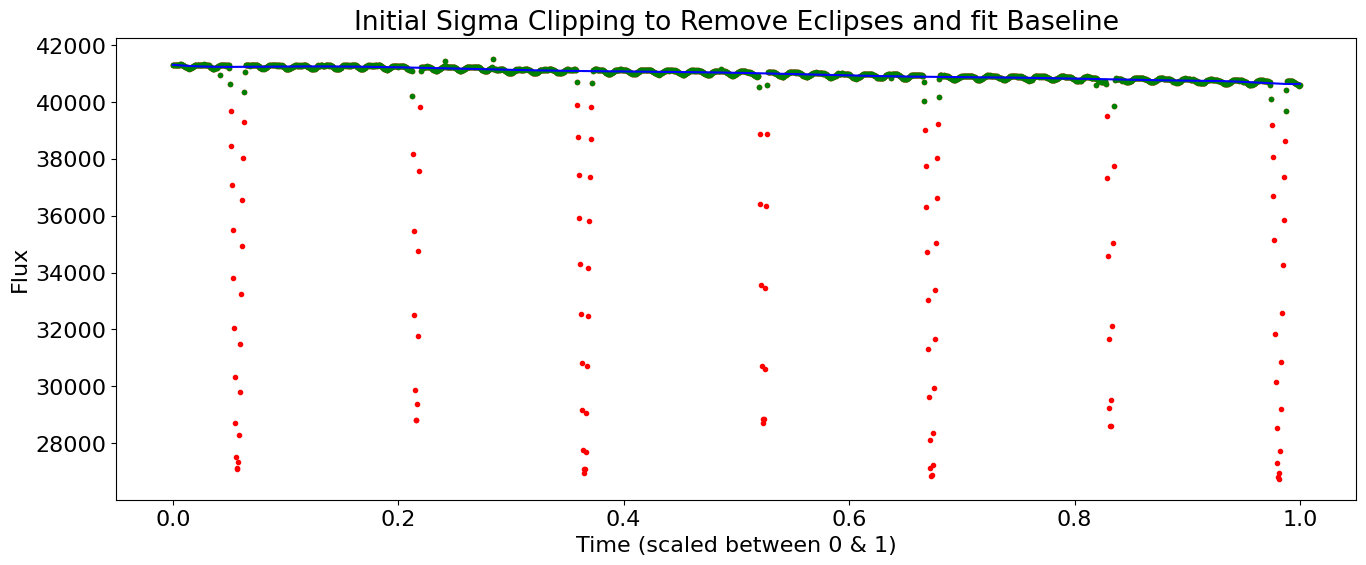

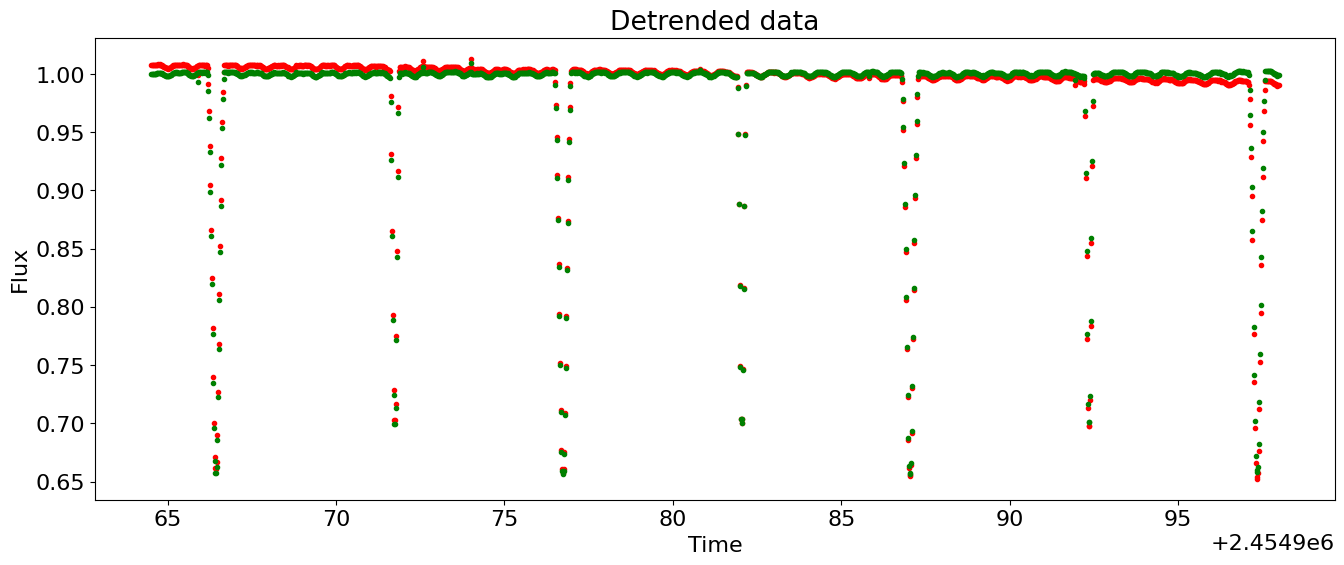

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2009259160929_llc.dat
start time: 2455002.520668
end time: 2455091.467913
261 datapoints culled
14 datapoints culled
0 datapoints culled


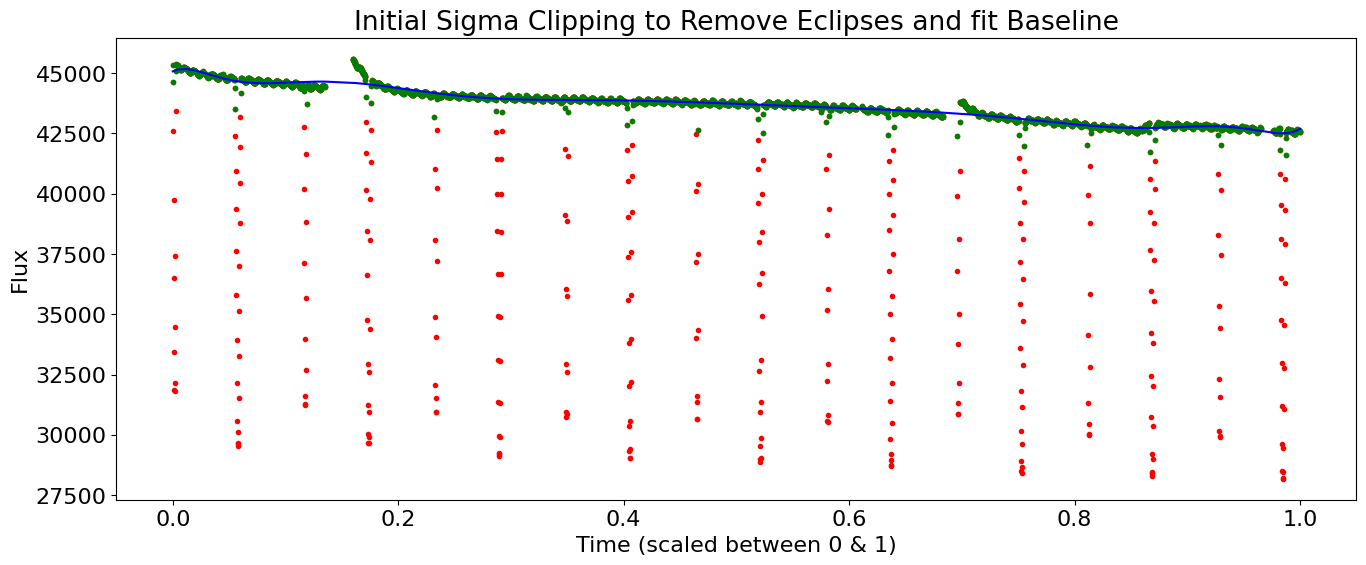

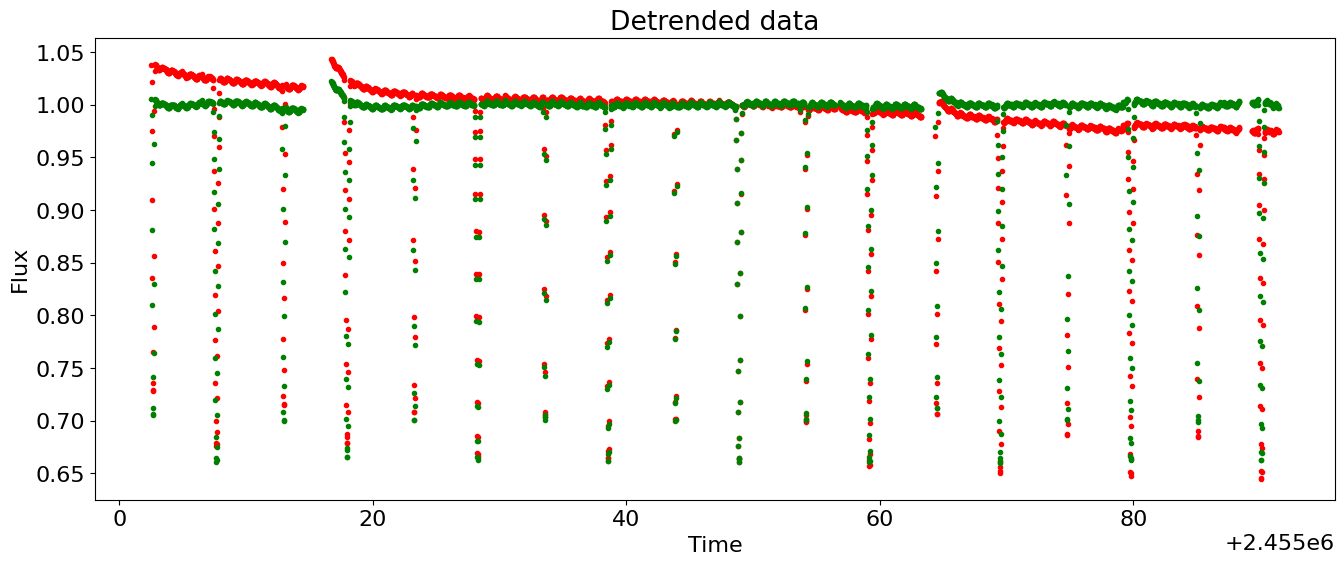

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2009350155506_llc.dat
start time: 2455093.225144
end time: 2455182.495251
240 datapoints culled
13 datapoints culled
0 datapoints culled


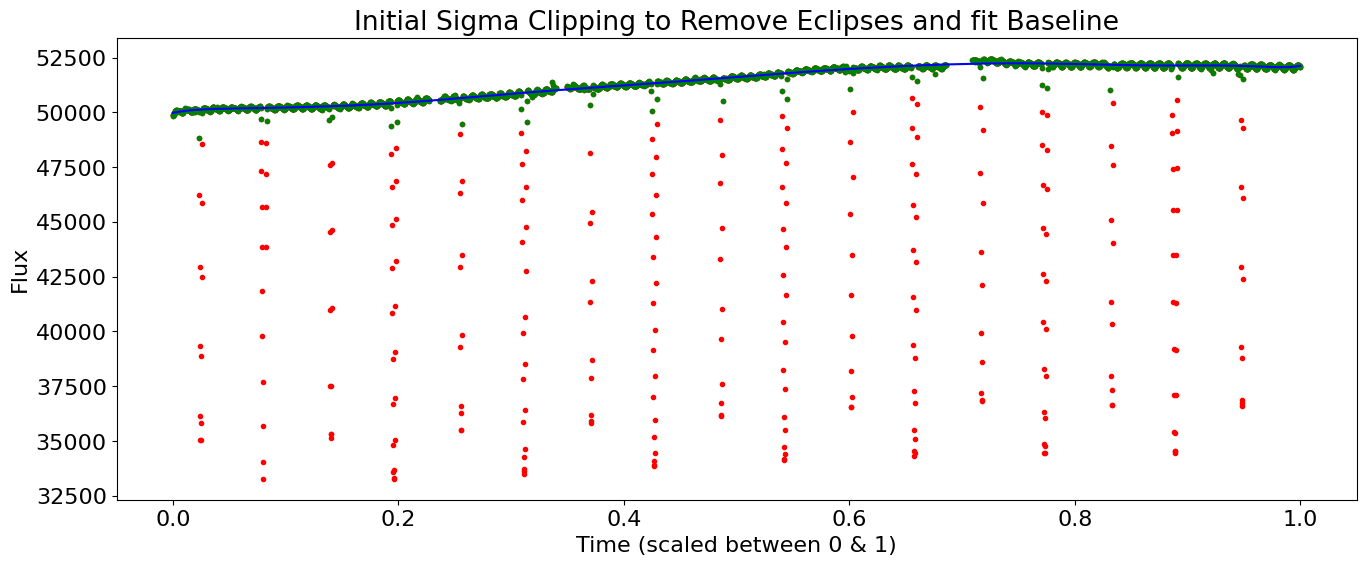

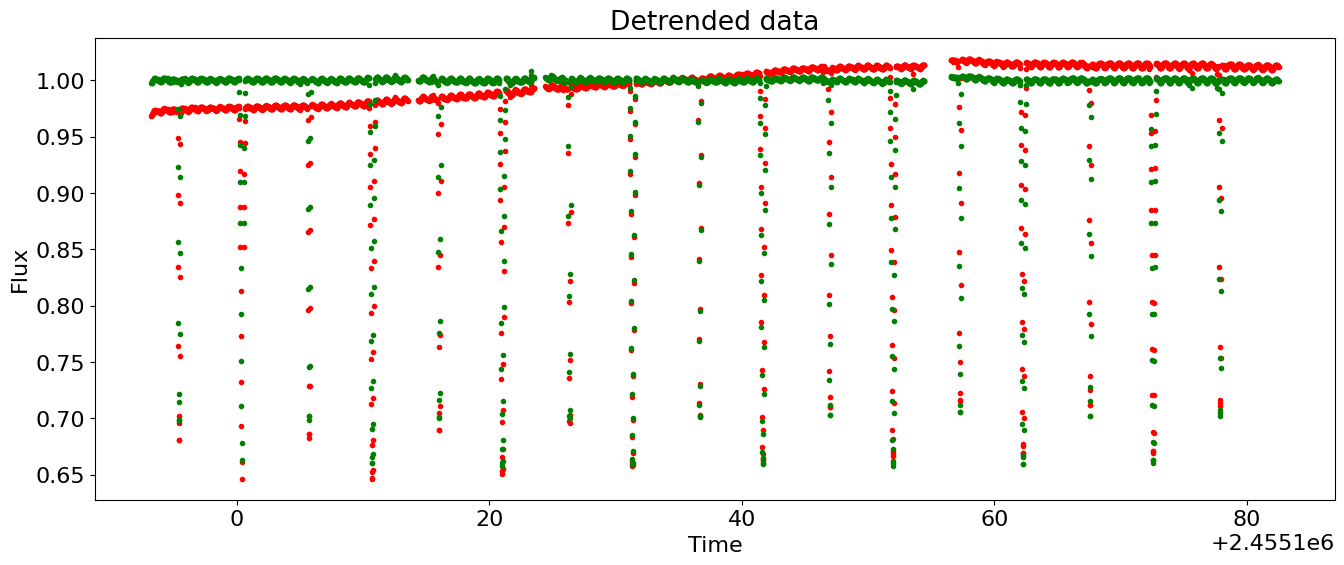

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2010078095331_llc.dat
start time: 2455185.37626
end time: 2455275.202587
245 datapoints culled
12 datapoints culled
0 datapoints culled


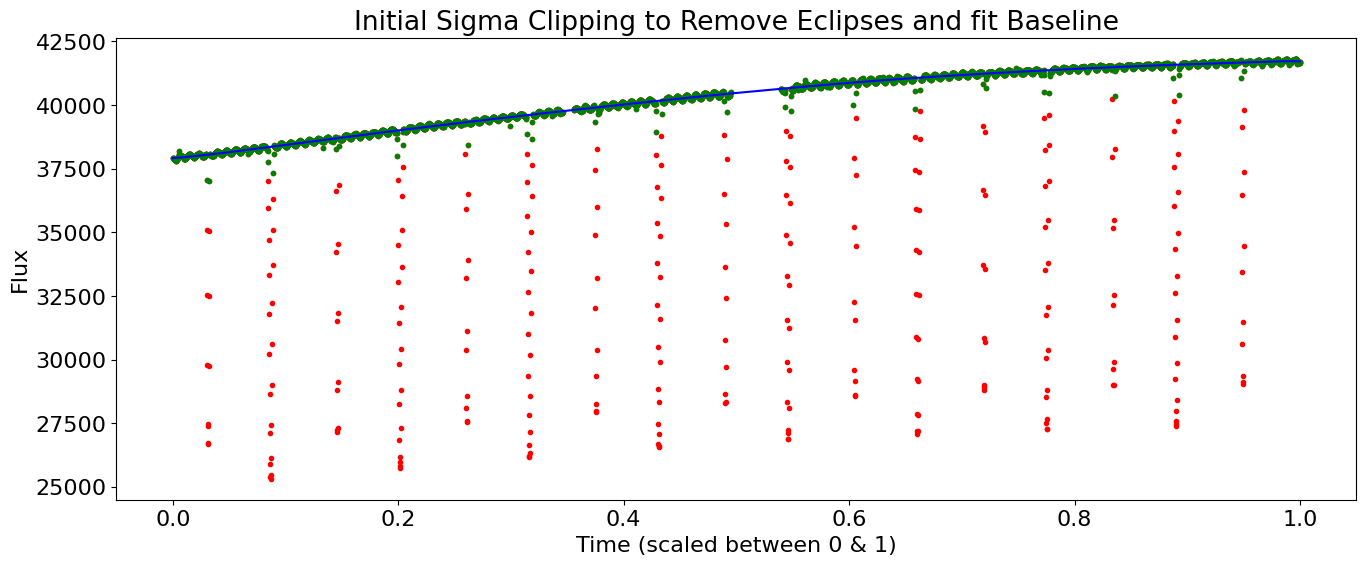

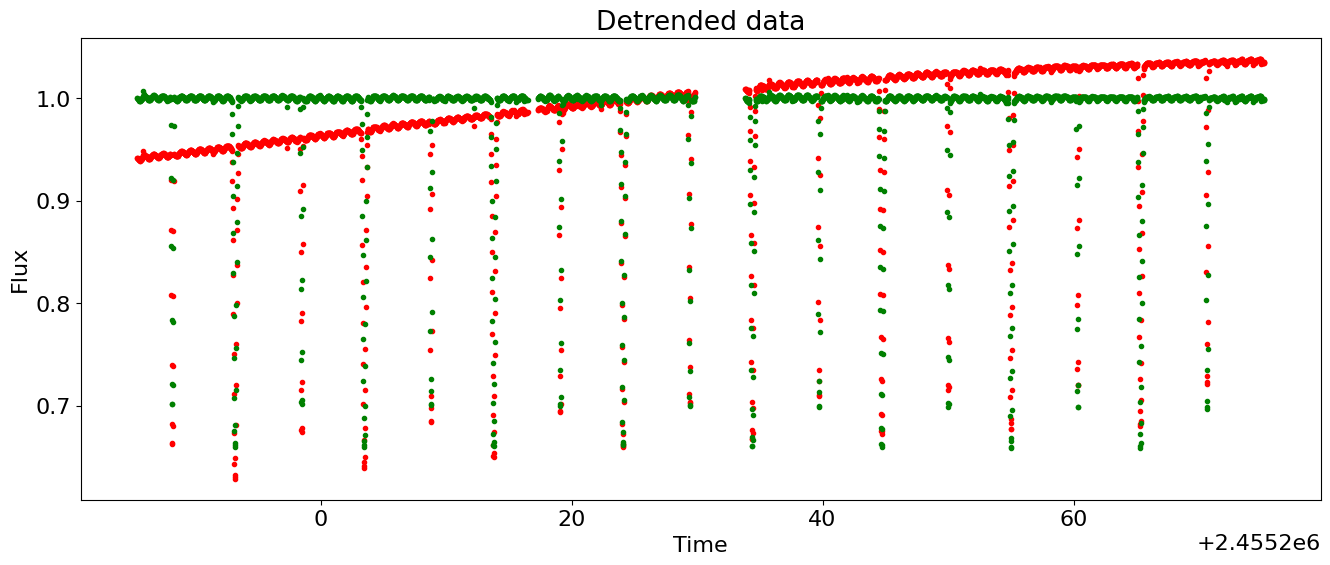

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2010174085026_llc.dat
start time: 2455276.489947
end time: 2455371.163154
253 datapoints culled
11 datapoints culled
0 datapoints culled


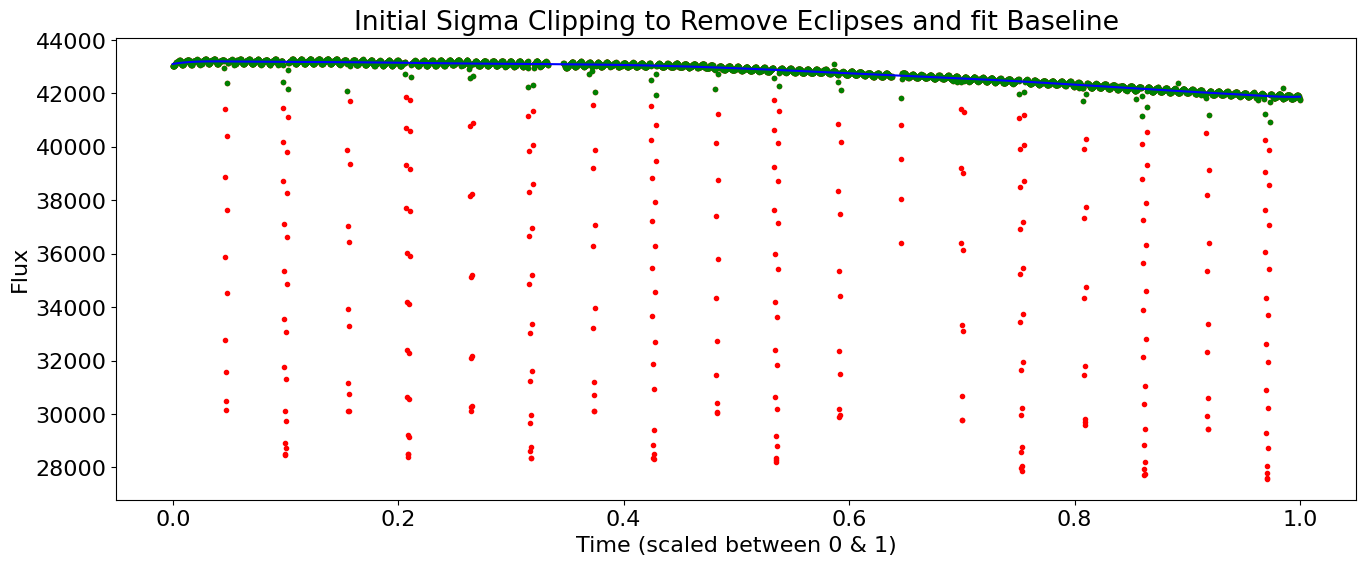

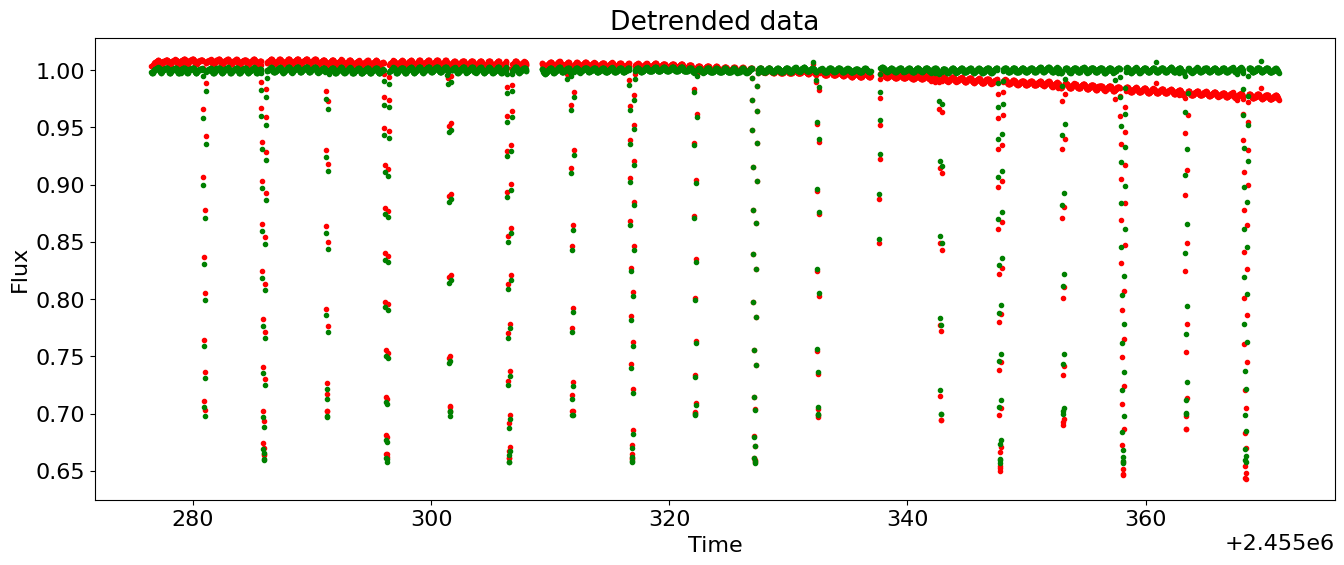

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2010265121752_llc.dat
start time: 2455372.47095
end time: 2455462.296876
264 datapoints culled
15 datapoints culled
0 datapoints culled


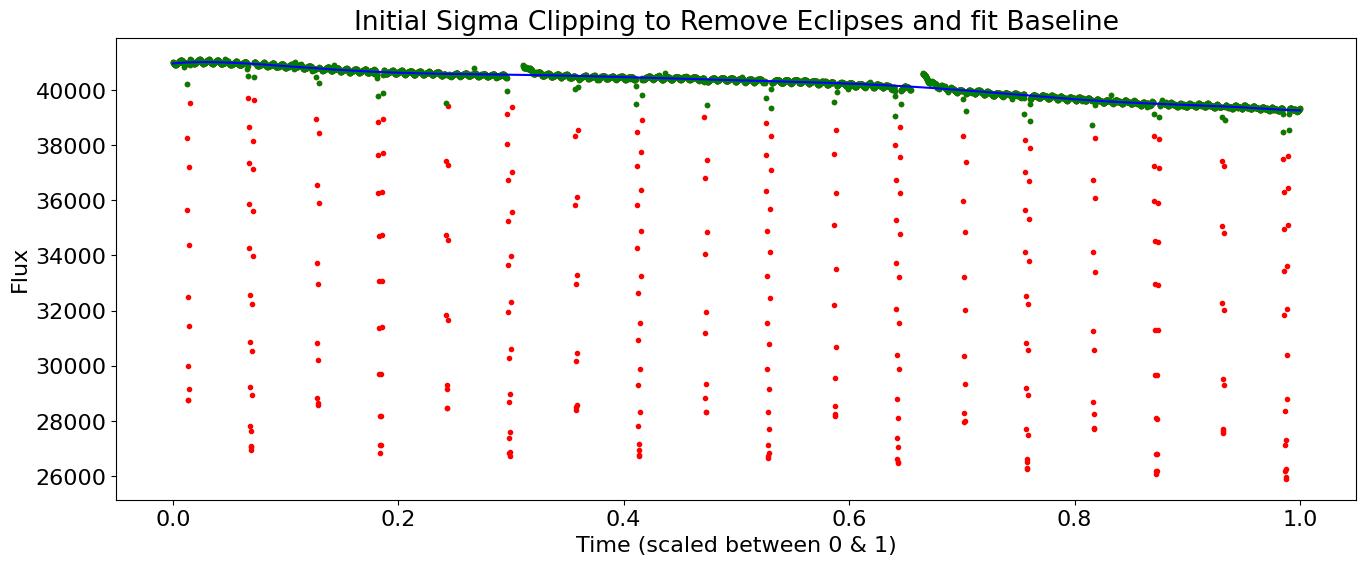

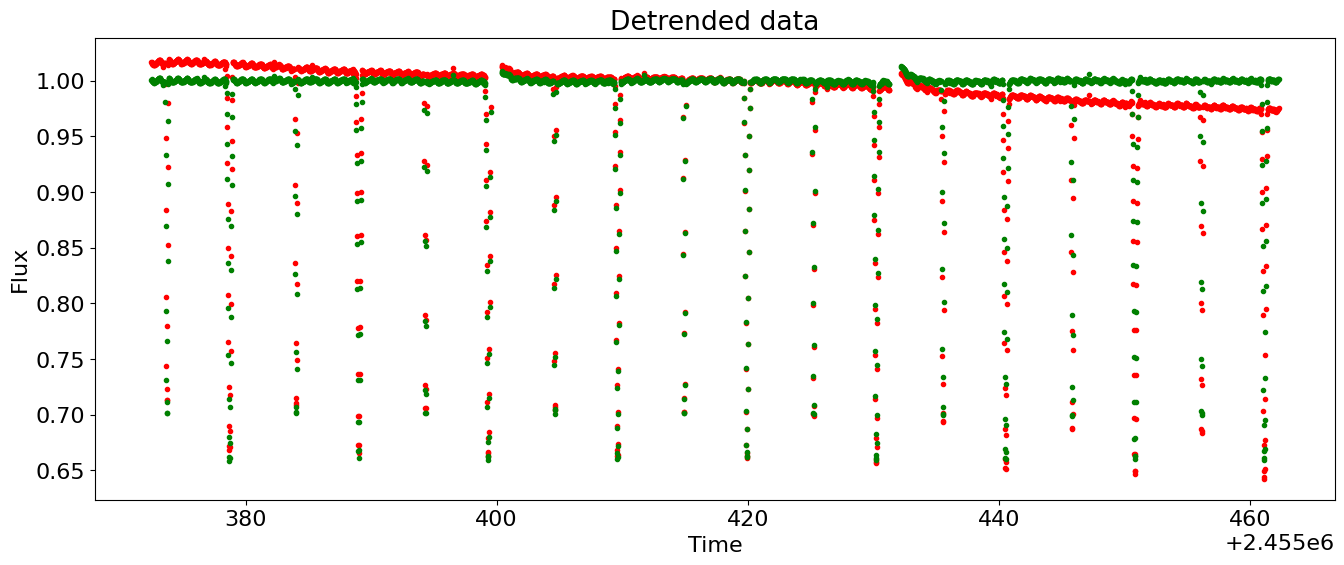

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2010355172524_llc.dat
start time: 2455463.175496
end time: 2455552.547802
245 datapoints culled
13 datapoints culled
0 datapoints culled


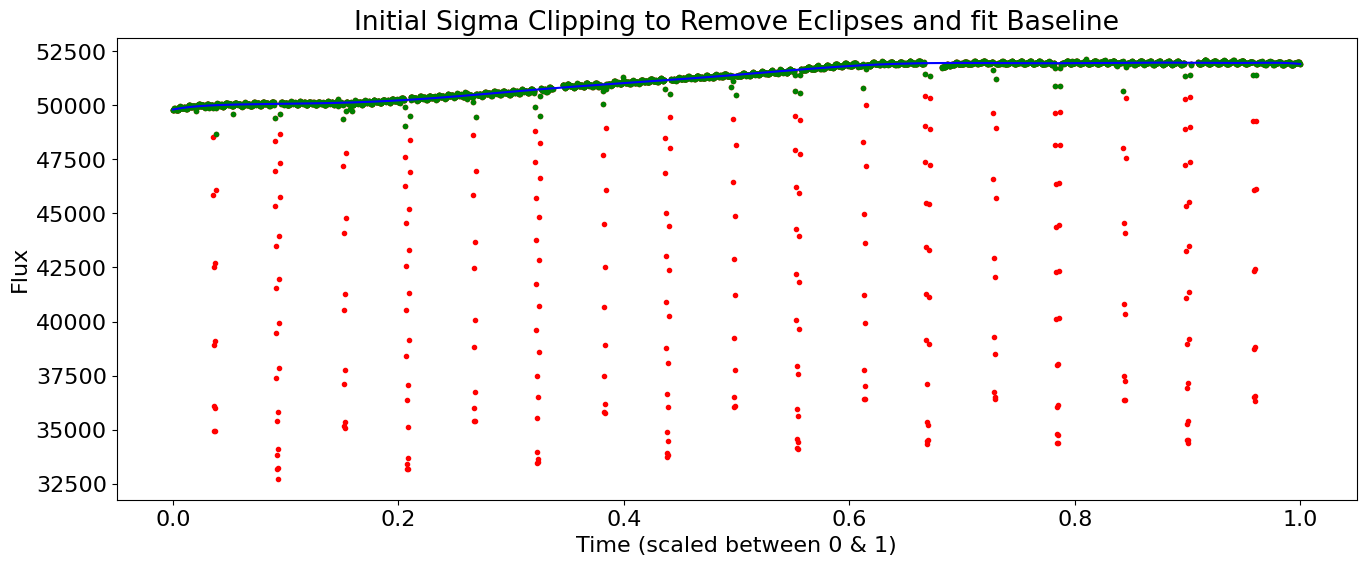

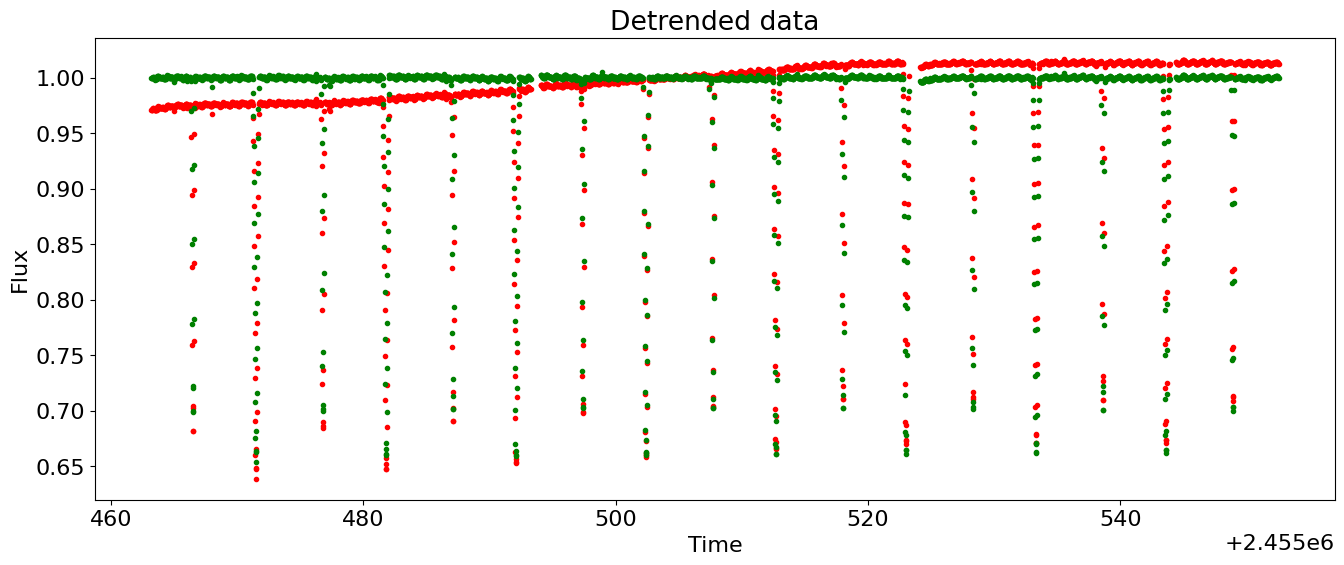

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2011073133259_llc.dat
start time: 2455568.362847
end time: 2455635.344369
171 datapoints culled
7 datapoints culled
0 datapoints culled


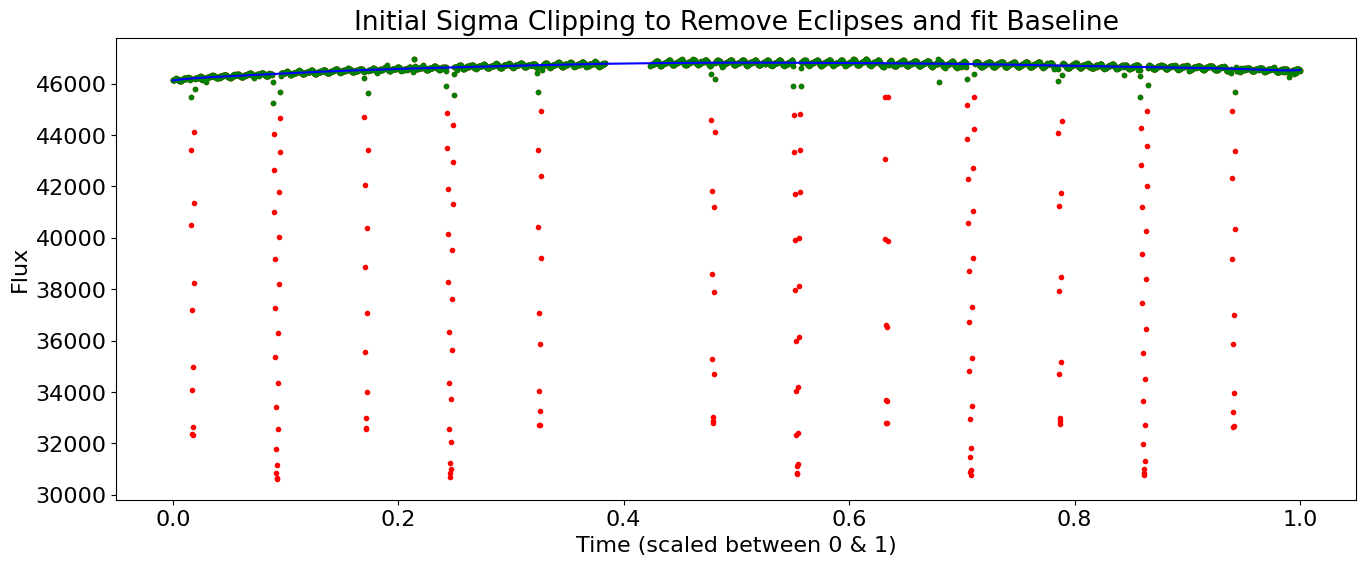

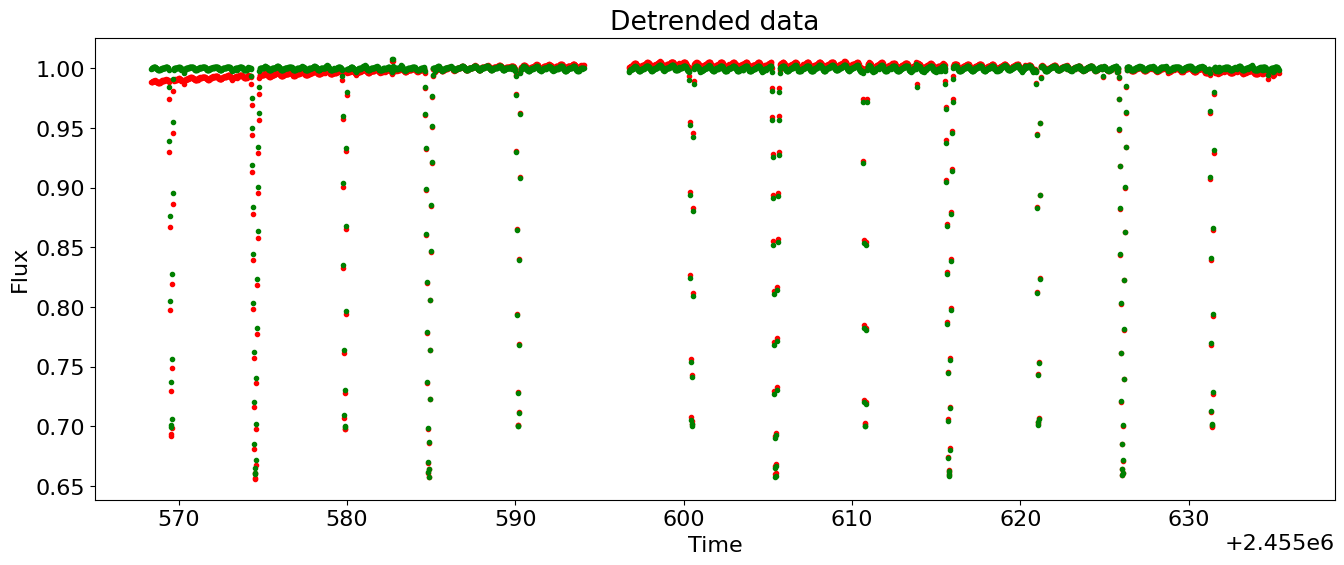

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2011177032512_llc.dat
start time: 2455641.515502
end time: 2455738.926943
276 datapoints culled
14 datapoints culled
0 datapoints culled


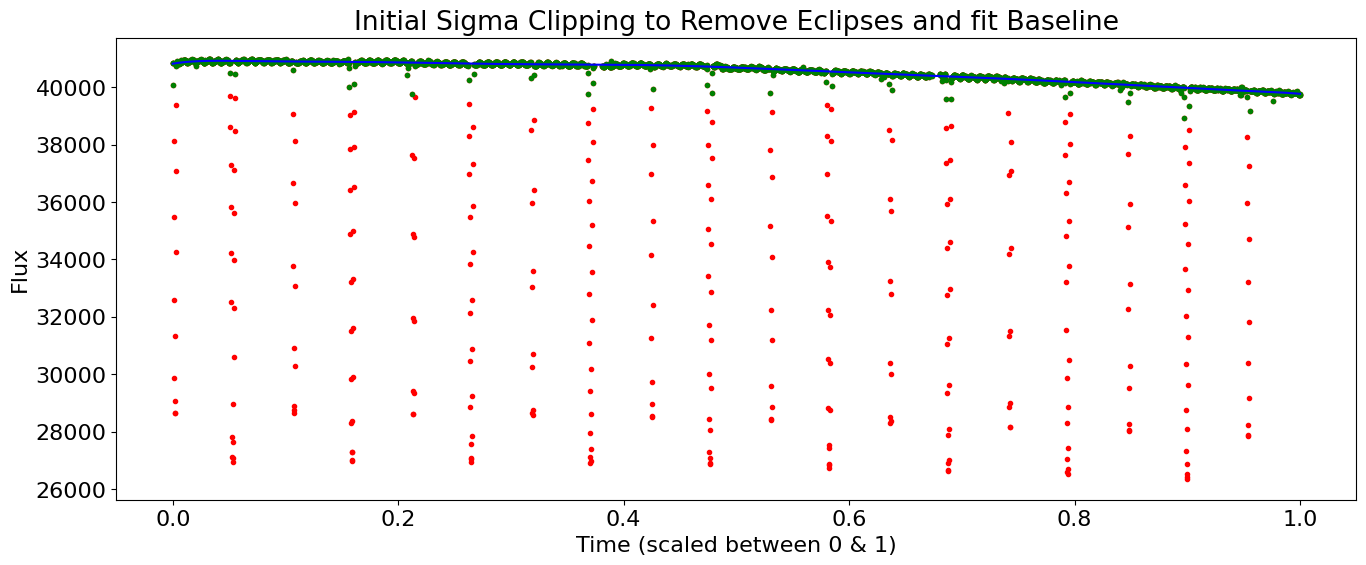

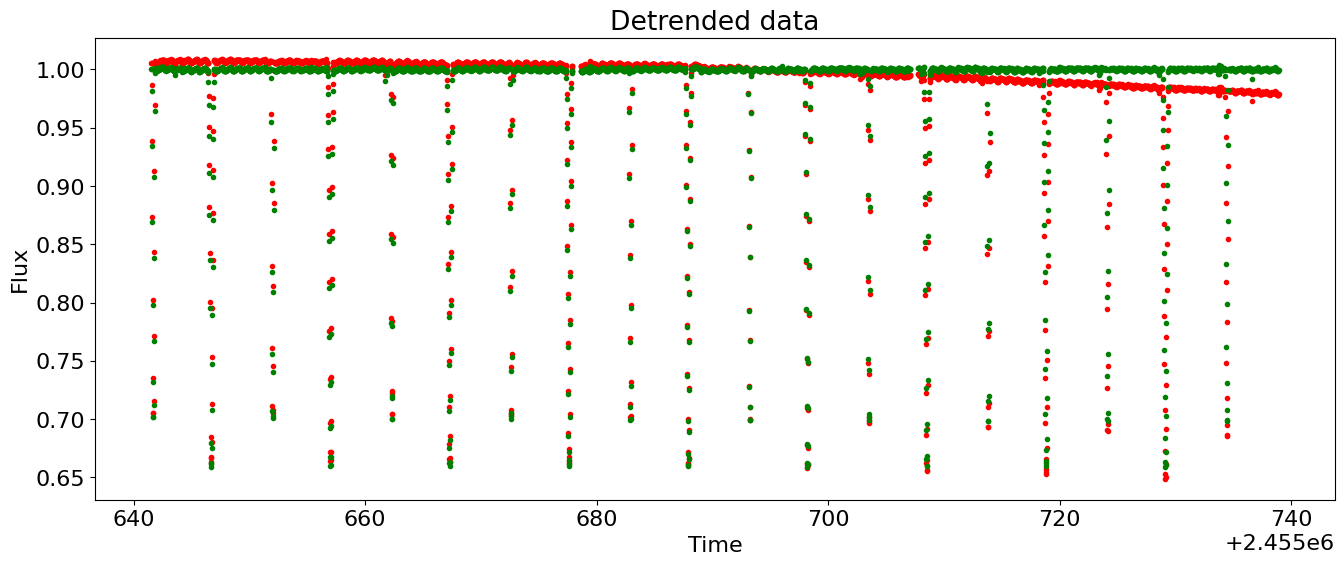

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2011271113734_llc.dat
start time: 2455739.846477
end time: 2455833.268933
246 datapoints culled
11 datapoints culled
0 datapoints culled


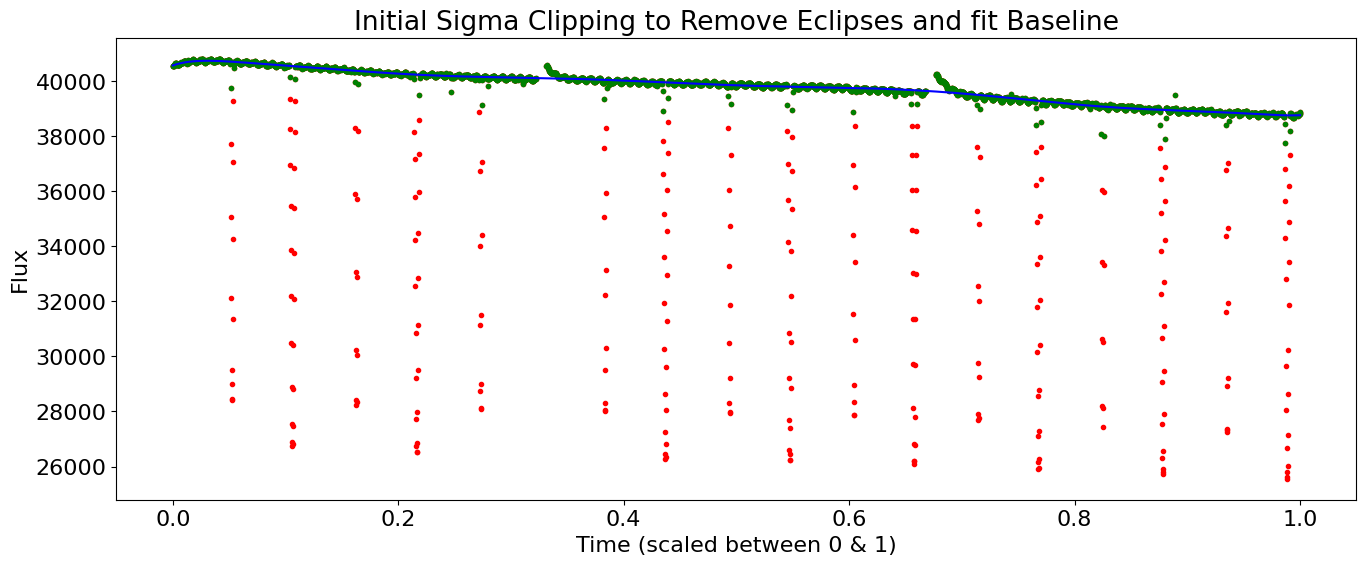

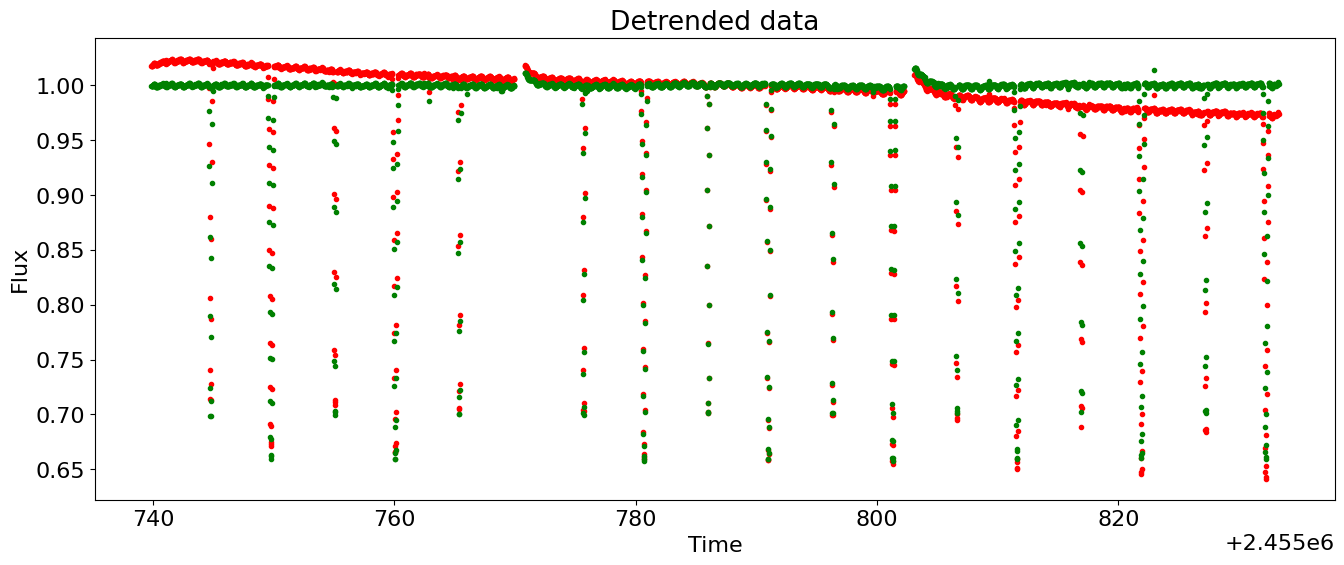

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2012004120508_llc.dat
start time: 2455834.208822
end time: 2455931.325159
257 datapoints culled
11 datapoints culled
0 datapoints culled


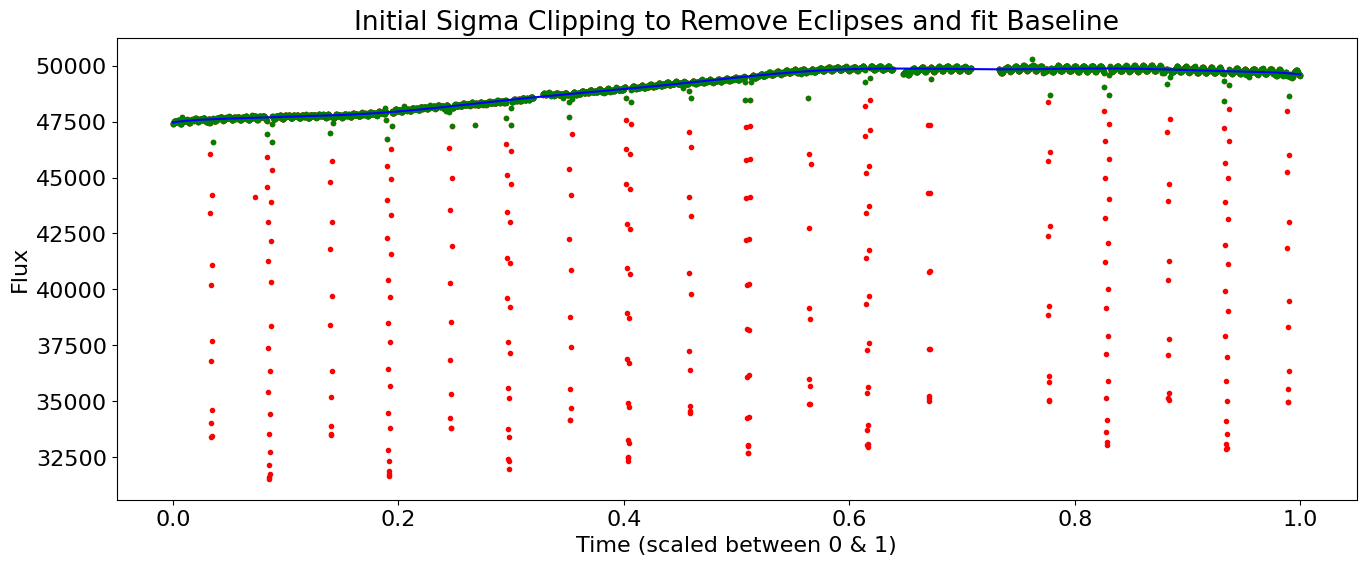

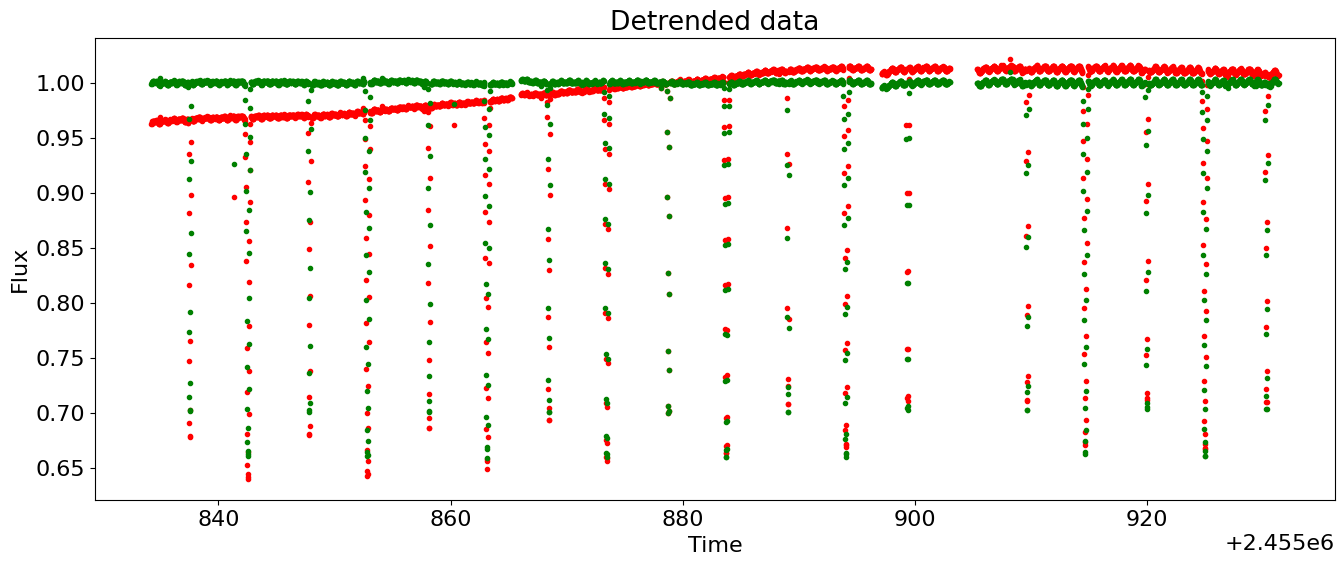

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2012088054726_llc.dat
start time: 2455932.408074
end time: 2456015.02133
237 datapoints culled
12 datapoints culled
0 datapoints culled


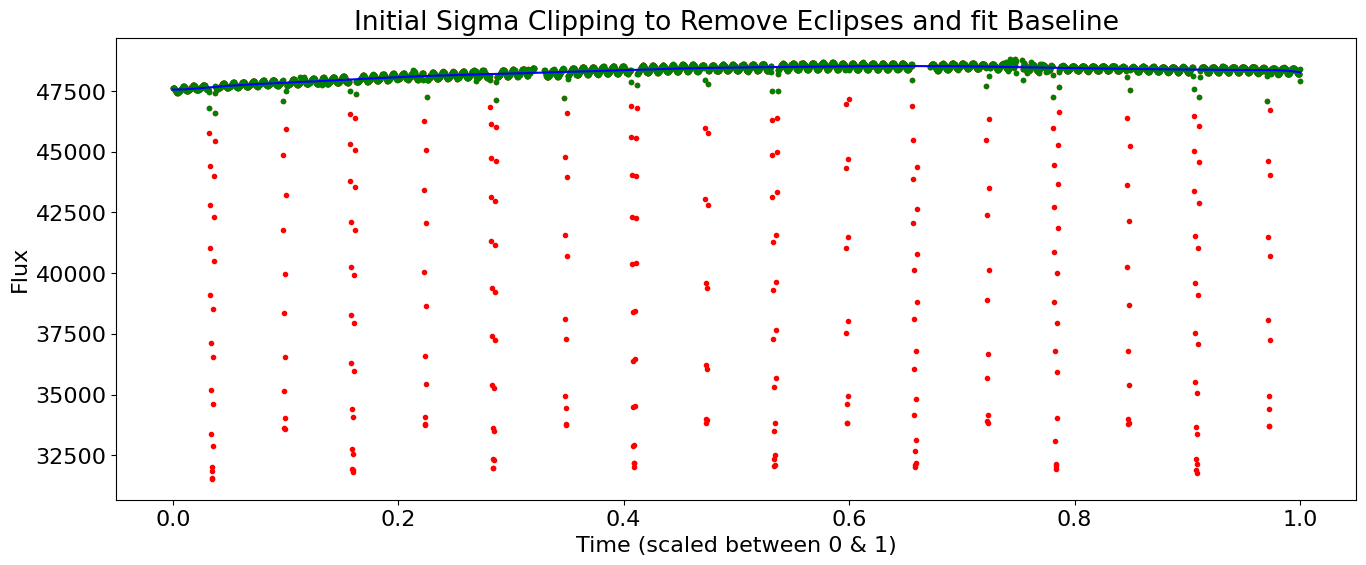

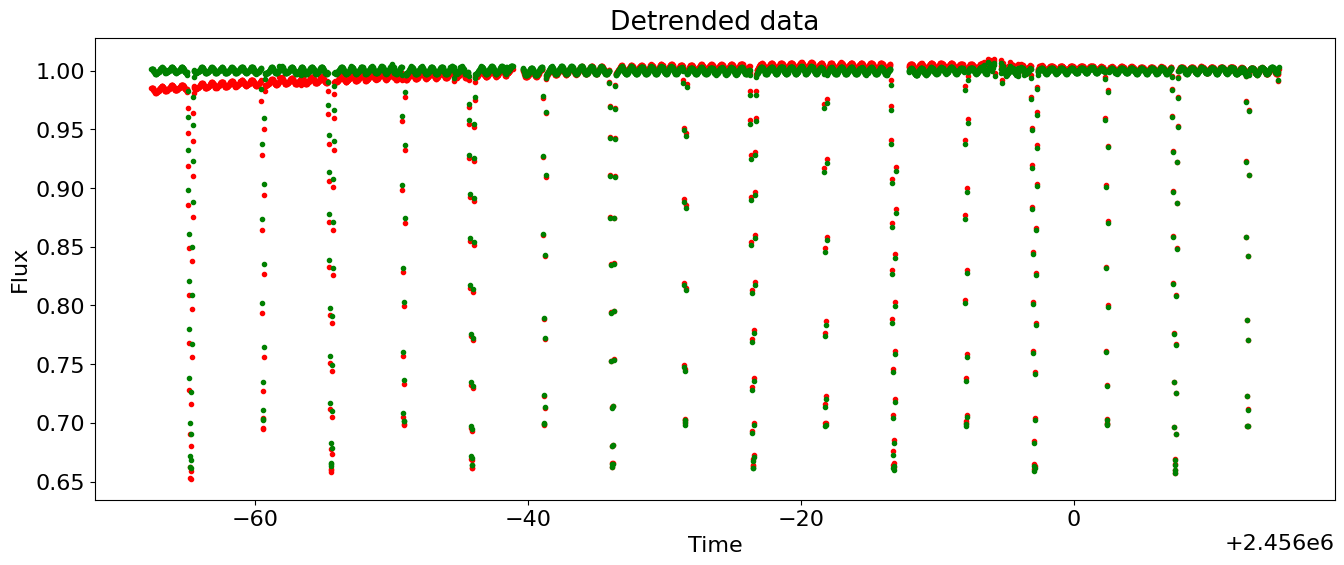

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2012179063303_llc.dat
start time: 2456015.736493
end time: 2456106.057214
257 datapoints culled
12 datapoints culled
0 datapoints culled


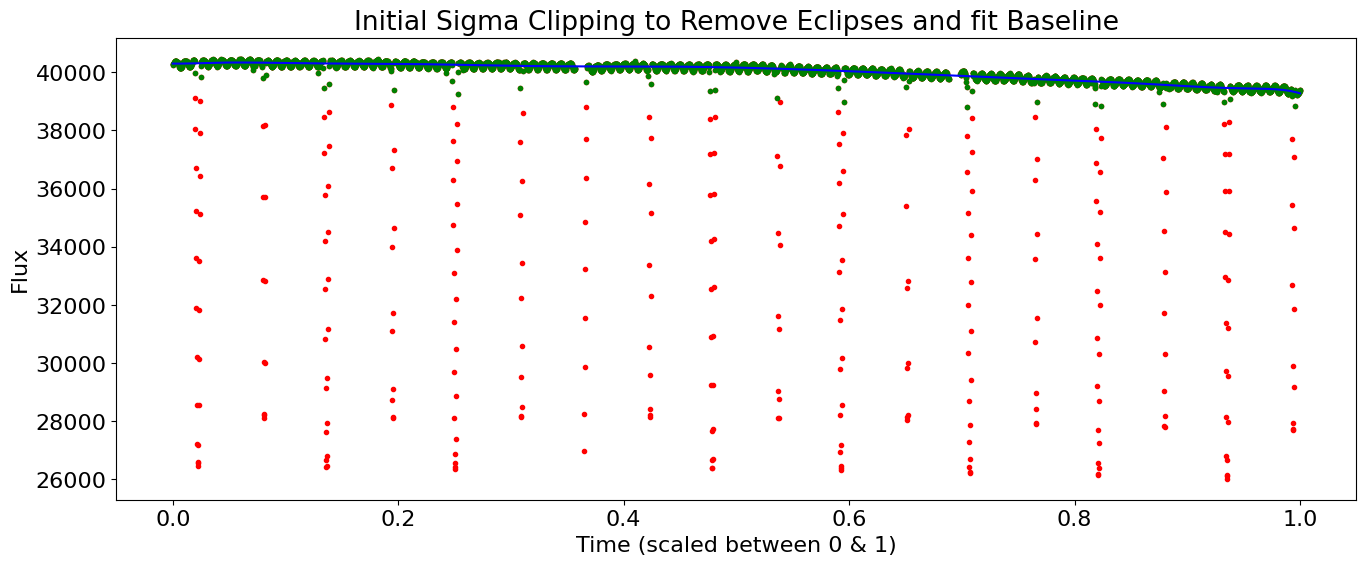

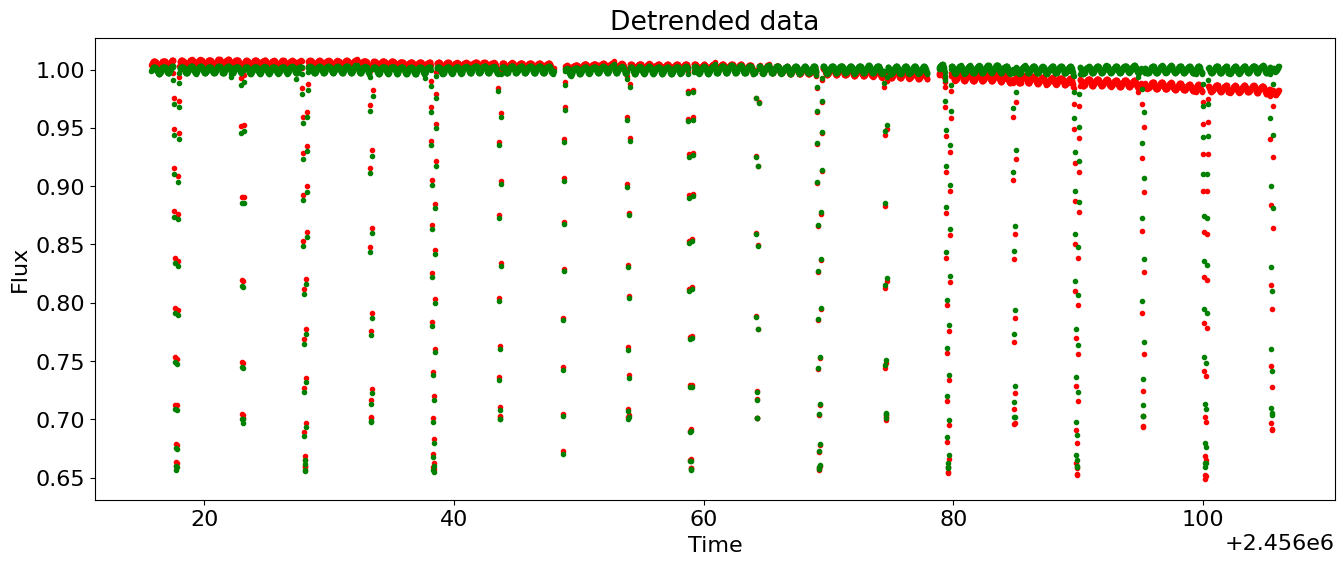

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2012277125453_llc.dat
start time: 2456107.140228
end time: 2456204.322692
271 datapoints culled
15 datapoints culled
0 datapoints culled


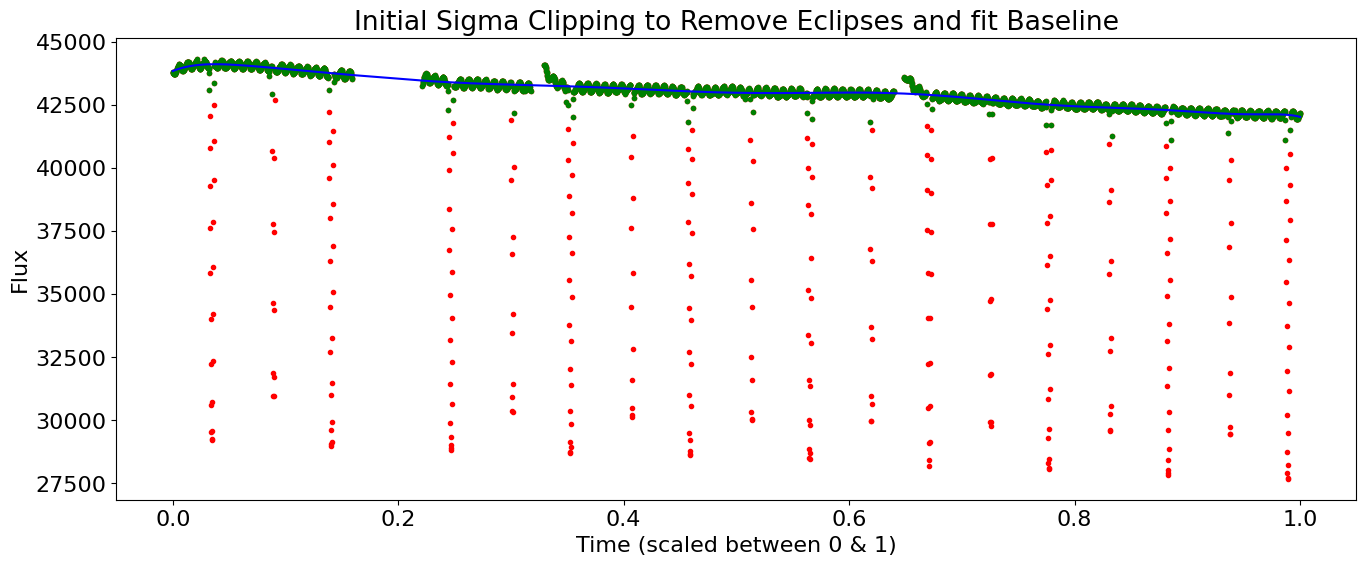

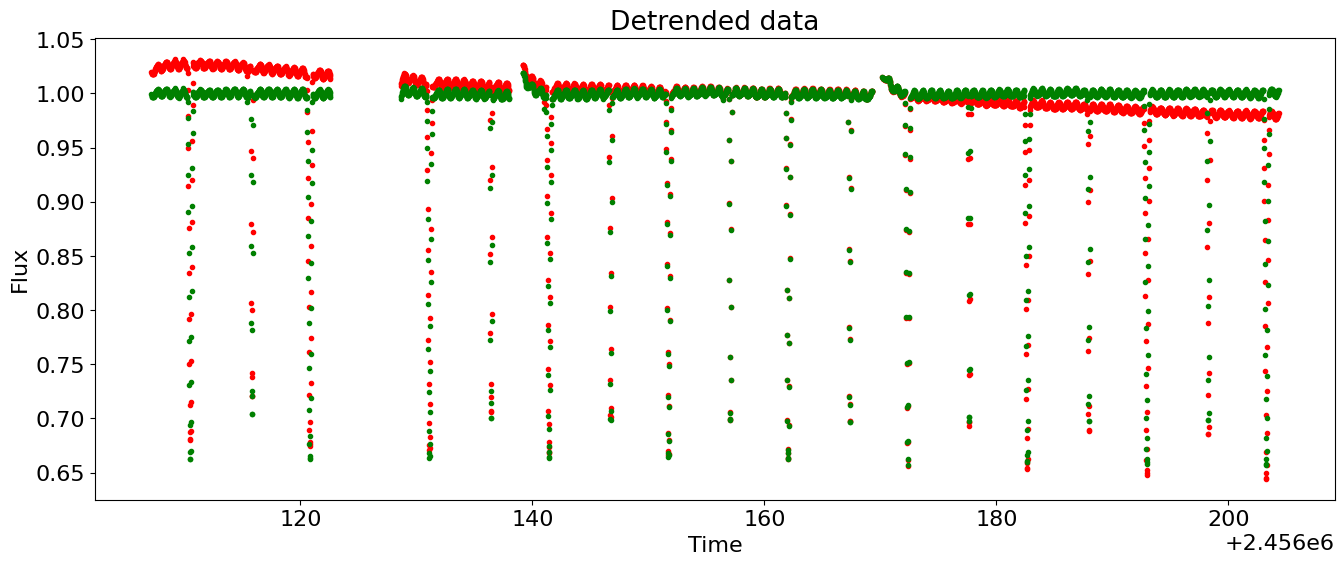

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2013011073258_llc.dat
start time: 2456206.488554
end time: 2456304.136156
266 datapoints culled
13 datapoints culled
0 datapoints culled


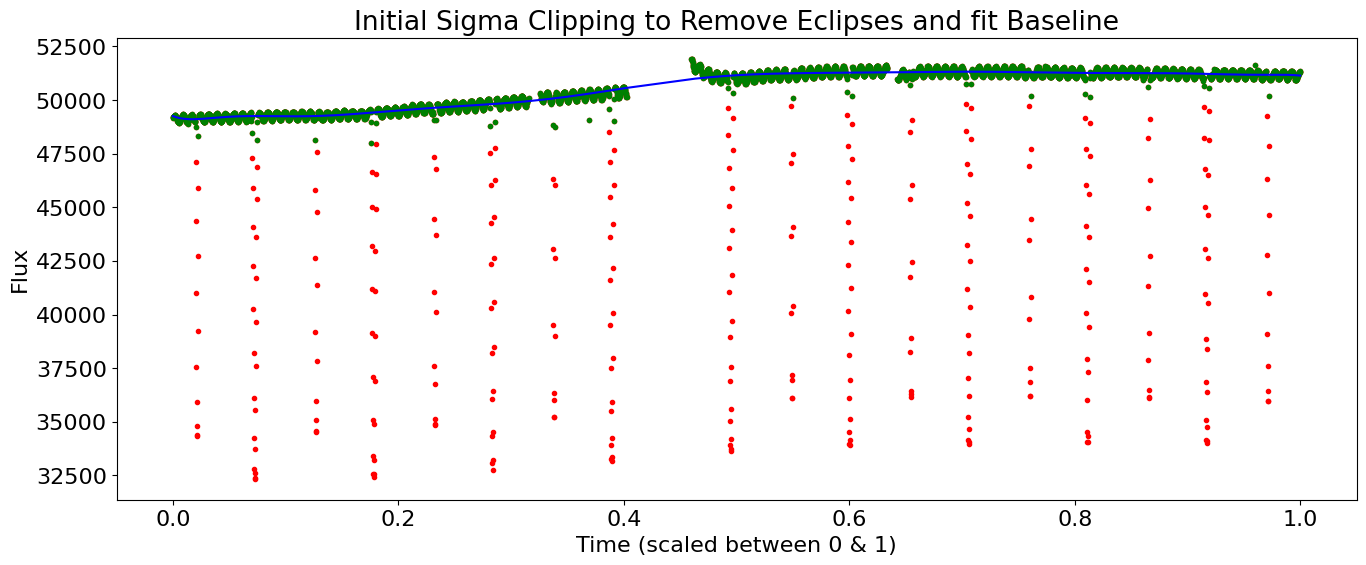

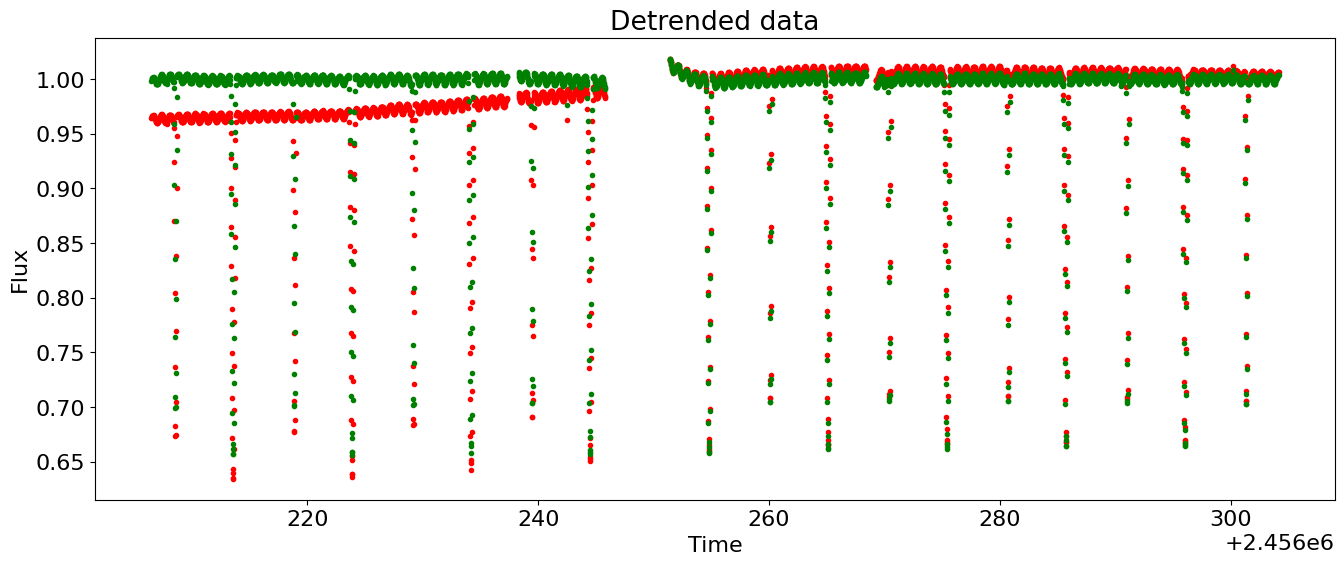

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2013098041711_llc.dat
start time: 2456305.116895
end time: 2456390.958799
222 datapoints culled
11 datapoints culled
0 datapoints culled


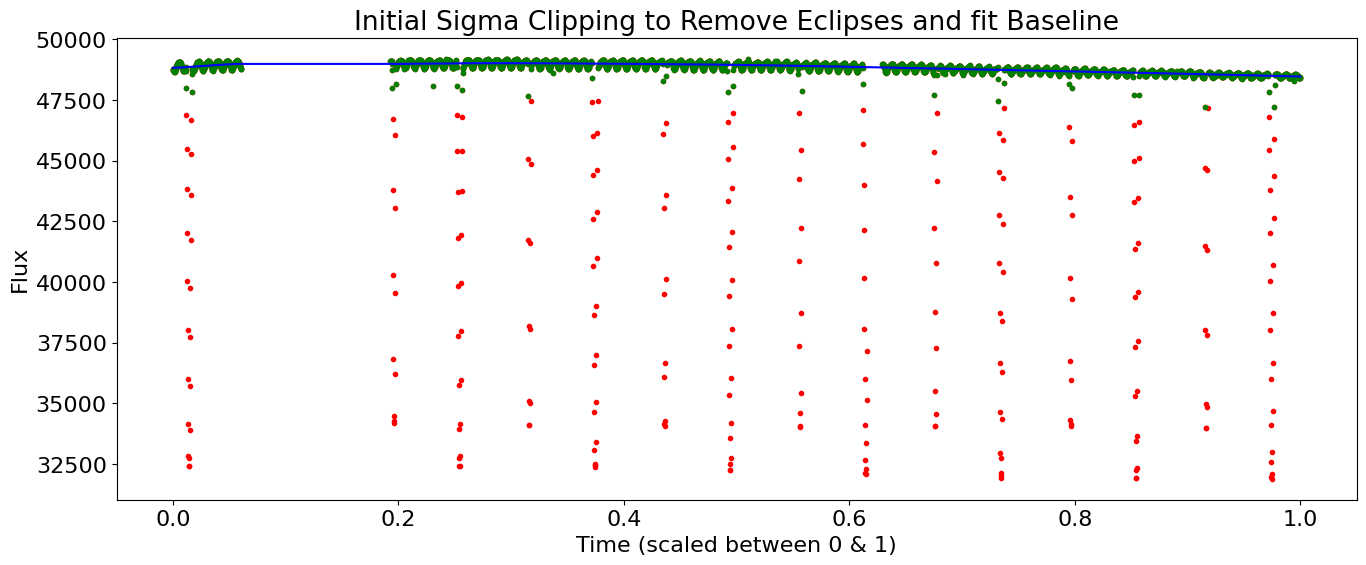

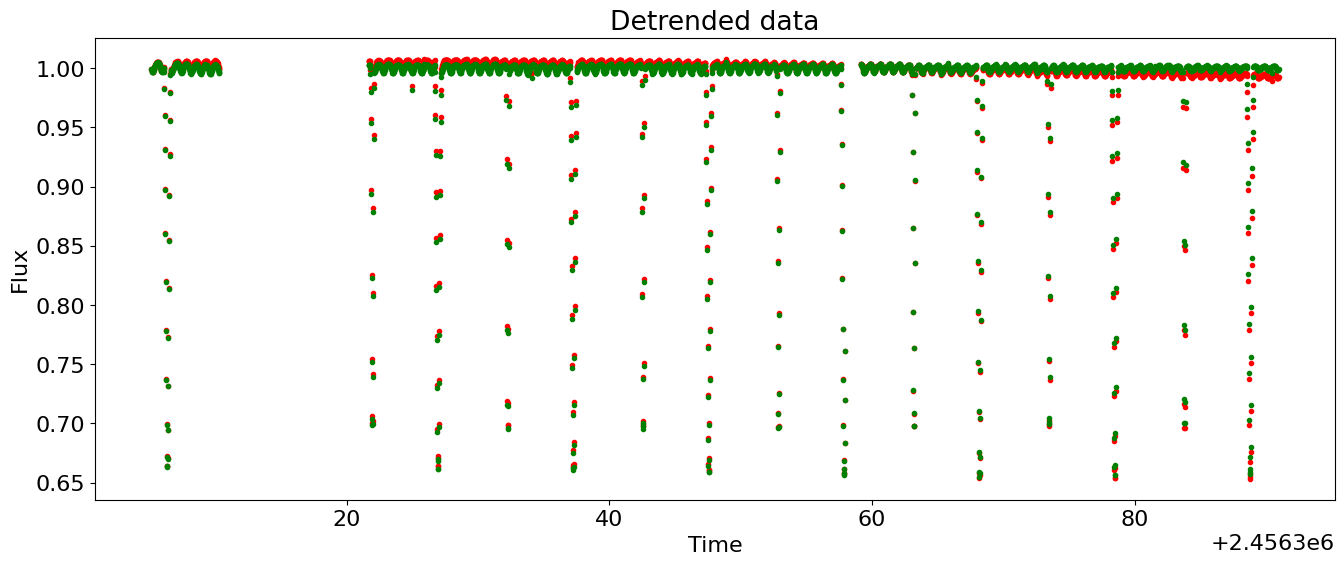

/mnt/c/Users/Karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/raw_data/kplr002306740-2013131215648_llc.dat
start time: 2456392.225698
end time: 2456424.001399
65 datapoints culled
3 datapoints culled
0 datapoints culled


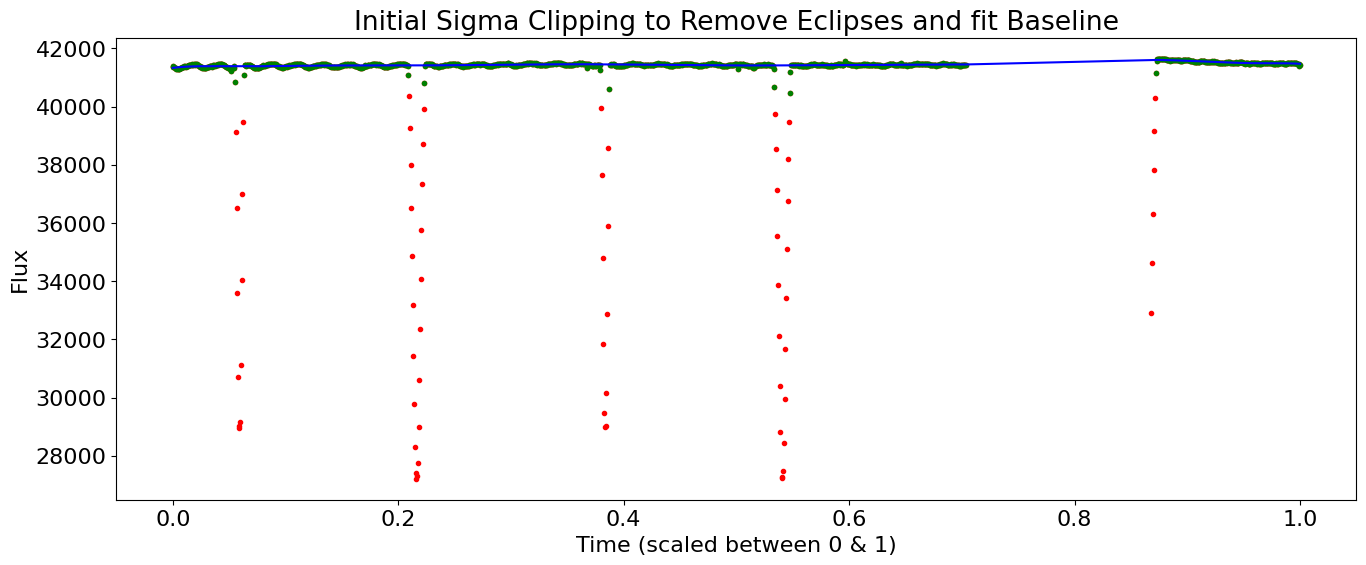

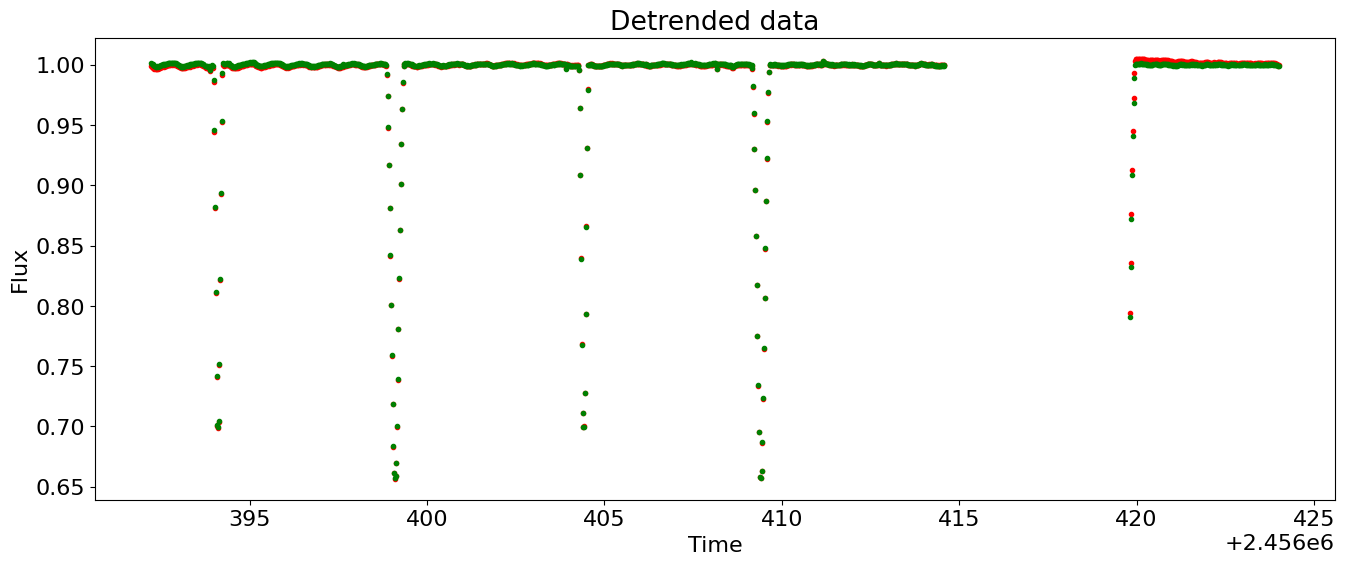

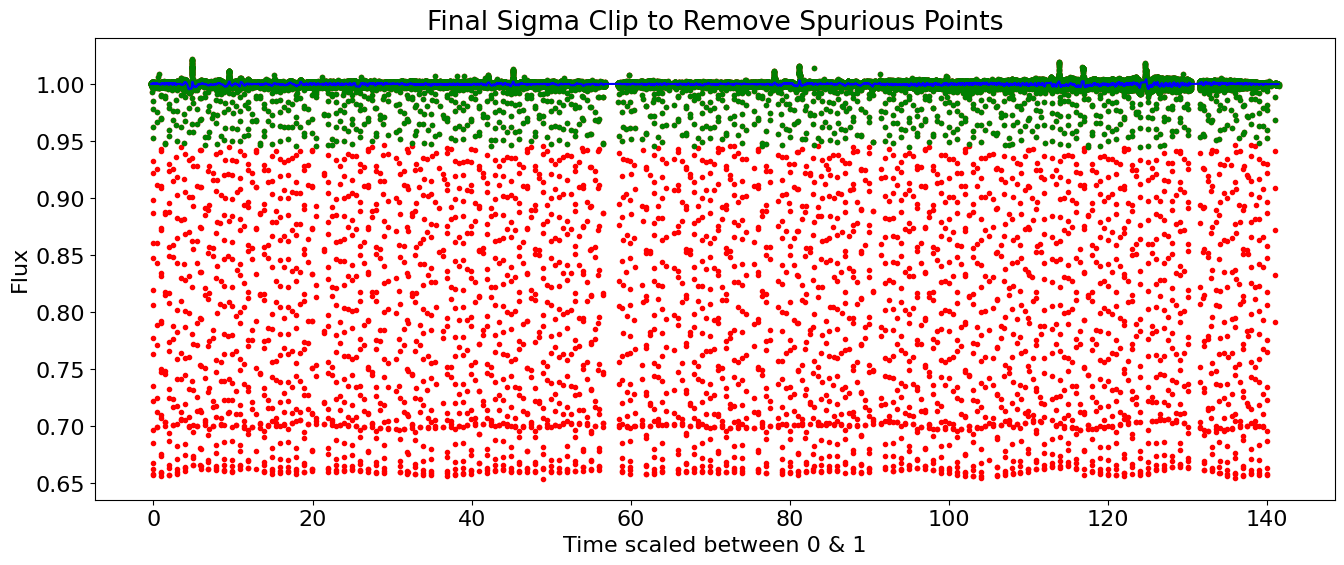

In [32]:
with open(detrended, 'w') as outfile:

    for i, file_name in enumerate (glob.glob((files + r"/kplr*dat"))):
        print(file_name)

        with open(file_name) as infile:
            lc = np.loadtxt(infile)
            all_data = detrend(lc, order, xi_h, xi_l, ztime, period)

            if (i == 0):
                complete = all_data
            else:
                complete = np.append(complete, all_data, axis = 0)
    
    final, baseline = final_sigclip(complete, final_xi_l, final_xi_h)

In [33]:
arg = np.argsort(final[:,0])
final = final[arg]

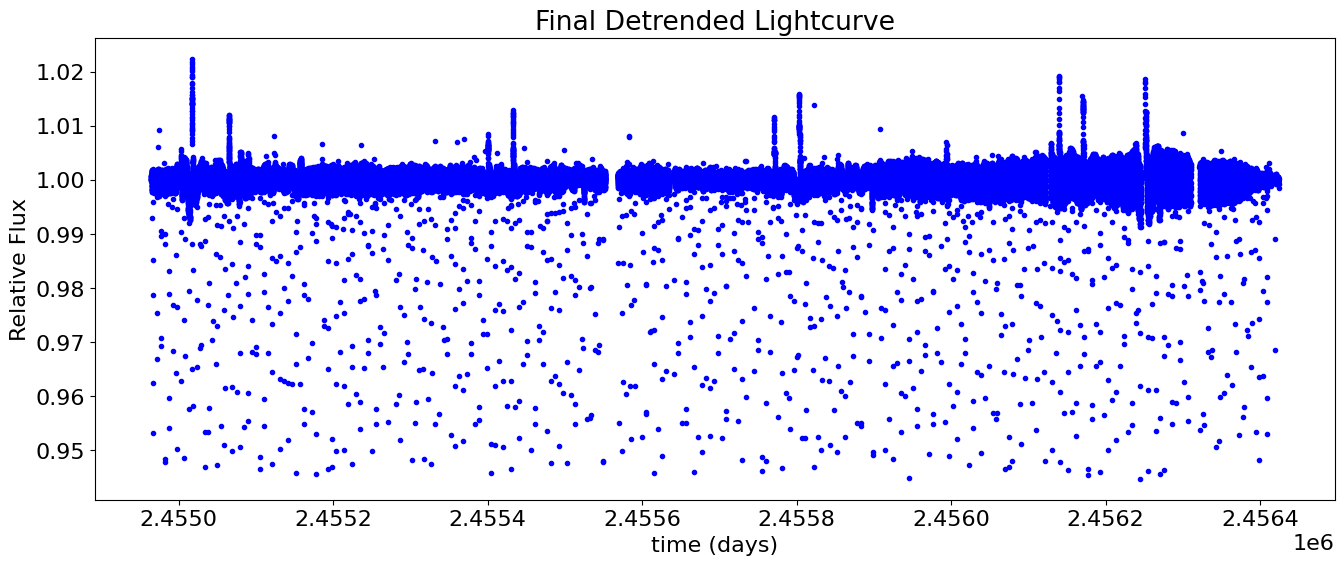

In [34]:
plt.plot(final[:,0], final[:,3], 'b.')
plt.title("Final Detrended Lightcurve")
plt.xlabel("time (days)")
plt.ylabel("Relative Flux")
plt.show()

In [35]:
final.shape

(61768, 6)